In [38]:
import pyreadr
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict,RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold, KFold, validation_curve, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, precision_recall_curve, roc_auc_score, matthews_corrcoef, precision_score, make_scorer,  SCORERS
from sklearn.utils import class_weight, compute_class_weight, compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from functools import partial
import matplotlib.pyplot as plt

# <u>Preprocess Data </u>

### Import Transcript Stability Data

In [1131]:
transcript_stability = pyreadr.read_r('transcript_stability_non_norm.RData')
transcript_stability = transcript_stability["transcript_stability"]
transcript_stability = pd.DataFrame(transcript_stability)

### Remove transcript version from id's (*.number)

In [1132]:
transcript_stability["transcript_id"] = transcript_stability["transcript_id"].str.split(".").str[0]

### Remove Housekeeping transcripts

In [1133]:
h = pd.read_csv("Housekeeping_TranscriptsHuman.csv", delimiter=";")
house_genes = h["Ensembl"].values
transcript_stability = transcript_stability[~transcript_stability["transcript_id"].isin(house_genes)]

### Define "stable" transcripts

In [1134]:
transcript_stability["stability"] = "NO"
transcript_stability_gcsi_ccle = transcript_stability.copy() 
transcript_stability_gdsc_ccle = transcript_stability.copy()
transcript_stability_gcsi_gdsc = transcript_stability.copy()

In [1135]:
transcript_stability_gcsi_ccle.loc[transcript_stability_gcsi_ccle["gcsi_ccle"] > 0.8, "stability"] = "YES"
transcript_stability_gcsi_ccle.loc[transcript_stability_gcsi_ccle["gcsi_ccle"] < 0.8, "stability"] = "NO"

In [1136]:
transcript_stability_gcsi_gdsc.loc[transcript_stability_gcsi_gdsc["gcsi_gdsc"] > 0.8, "stability"] = "YES"
transcript_stability_gcsi_gdsc.loc[transcript_stability_gcsi_gdsc["gcsi_gdsc"] < 0.8, "stability"] = "NO"

In [1137]:
transcript_stability_gdsc_ccle.loc[transcript_stability_gdsc_ccle["gdsc_ccle"] > 0.8, "stability"] = "YES"
transcript_stability_gdsc_ccle.loc[transcript_stability_gdsc_ccle["gdsc_ccle"] < 0.8, "stability"] = "NO"

### Isolate most unstable + most stable for artificial model

#### gCSI/CCLE

In [1138]:
stable = transcript_stability_gcsi_ccle[transcript_stability_gcsi_ccle["stability"]=="YES"]

In [1139]:
len(stable)

3622

In [1140]:
unstable = transcript_stability_gcsi_ccle[(transcript_stability_gcsi_ccle["gcsi_ccle"] < -0.06)]

In [1141]:
transcript_stability_gcsi_ccle = stable.append(unstable)

In [1142]:
len(stable)

3622

In [1143]:
len(unstable)

3669

#### gCSI/GDSC

In [1144]:
stable = transcript_stability_gcsi_gdsc.loc[transcript_stability_gcsi_gdsc["gcsi_gdsc"] > 0.8]

In [1145]:
unstable = transcript_stability_gcsi_gdsc[(transcript_stability_gcsi_gdsc["gcsi_gdsc"] < -0.02)]

In [1146]:
transcript_stability_gcsi_gdsc = stable.append(unstable)

In [1147]:
len(transcript_stability_gcsi_gdsc[transcript_stability_gcsi_gdsc["stability"]!='YES'])

5471

In [1148]:
len(stable)

5479

In [1149]:
len(unstable)

5471

#### GDSC/CCLE

In [1150]:
stable = transcript_stability_gdsc_ccle.loc[transcript_stability_gdsc_ccle["gdsc_ccle"] > 0.8]

In [1151]:
unstable = transcript_stability_gdsc_ccle[(transcript_stability_gdsc_ccle["gdsc_ccle"] < -0.031)]

In [1152]:
transcript_stability_gdsc_ccle = stable.append(unstable)

In [1153]:
len(stable)

5089

In [1154]:
len(unstable)

5024

### Extract median expression & spearman stability only 

In [1155]:
transcript_stability_gcsi_ccle = transcript_stability_gcsi_ccle.loc[:,['length','stability']]

In [1156]:
transcript_stability_gcsi_gdsc = transcript_stability_gcsi_gdsc.loc[:,['length','stability']]

In [1157]:
transcript_stability_gdsc_ccle = transcript_stability_gdsc_ccle.loc[:,['length','stability']]

### Show dataset inbalance

YES    3622
NO     3534
Name: stability, dtype: int64


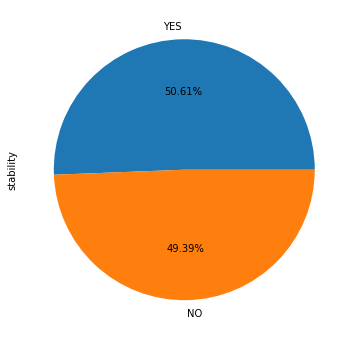

In [322]:
plt.figure(figsize=(6,6))
pd.Series(transcript_stability['stability']).value_counts().plot(kind ='pie', autopct='%1.2f%%')
print(pd.Series(transcript_stability['stability']).value_counts())

# <u>Build Random Forest classifier </u>

## 1. Basic Random Forest Classifier with k-fold cross validation

In [498]:
x1 = transcript_stability_gcsi_ccle[["gdsc_median"]].values # convert into 2D array
#x1 = transcript_stability["combined_median"].values.reshape(-1, 1)
y1 = transcript_stability_gcsi_ccle["stability"].values.ravel() # convert into 1D array
rf = RandomForestClassifier(n_estimators=100, random_state=42) #define classifier with n trees
k_fold = KFold(n_splits=10) 
repeated_kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

In [499]:
rf_scores = cross_val_score(rf, x1, y1, cv=repeated_kfold, n_jobs=2, pre_dispatch=4)

In [500]:
print("Accuracy: %.2f%%" % (rf_scores.mean()*100.0))

Accuracy: 73.51%


### Obtain confusion matrix for predicted values

In [501]:
rf_pred = cross_val_predict(rf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
labels = np.unique(y1)
rf_conf_mat = confusion_matrix(y1, rf_pred, labels=labels)

In [502]:
pd.DataFrame(rf_conf_mat, index=labels, columns=labels)

,NO,YES
NO,6063,1457
YES,2917,4730


In [503]:
print(recall_score(y1, rf_pred, pos_label="YES"))
print(precision_score(y1, rf_pred, pos_label="YES"))
print(f1_score(y1, rf_pred, pos_label="YES"))

0.6185432195632274
0.7645062227250687
0.6838224663871622


In [504]:
rf_y1 = np.where(y1 =="YES", True, False)
rf_pred2 = np.where(rf_pred =="YES", True, False)
rf_roc_auc = roc_auc_score(rf_y1, rf_pred2)

In [505]:
rf_roc_auc

0.7123966097816137

In [163]:
x1 = transcript_stability[["combined_median"]].values
x2 = transcript_stability[["length"]].values
x3 = transcript_stability[["combined_mad"]].values
x4 = transcript_stability[["gc"]].values
x5 = transcript_stability[["exons"]].values

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")

# median expression
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x1, y=y1, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(median exp)')

# length
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x2, y=y1, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="b", label='CV(transcript length)')

# Median MAD
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x3, y=y1, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="r", label='CV(median MAD)')


# GC content
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x4, y=y1, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="orange", label='CV(GC%)')


# Exon Number
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x5, y=y1, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="black", label='CV(Exon #)')

plt.grid()
plt.legend(loc='upper left')
plt.savefig('figure_1.png', dpi=500)
plt.close()

In [1158]:
x1 = transcript_stability_gcsi_ccle[["length"]].values
x2 = transcript_stability_gcsi_gdsc[["length"]].values
x3 = transcript_stability_gdsc_ccle[["length"]].values

#x1 = transcript_stability_gcsi_ccle[["gdsc_median"]].values
#x2 = transcript_stability_gcsi_gdsc[["ccle_median"]].values
#x3 = transcript_stability_gdsc_ccle[["gcsi_median"]].values

y1 = transcript_stability_gcsi_ccle[["stability"]].values.ravel()
y2 = transcript_stability_gcsi_gdsc[["stability"]].values.ravel()
y3 = transcript_stability_gdsc_ccle[["stability"]].values.ravel()

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")


train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x1, y=y1, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(gcsi_ccle)-length')


train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x2, y=y2, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="b", label='CV(gcsi_gdsc)-length')


train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), 
X=x3, y=y3, cv=repeated_kfold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="r", label='CV(gdsc_ccle)-length')


plt.grid()
plt.legend(loc='upper left')
plt.savefig('figure_4.png', dpi=500)
plt.close()

### Plot Precision-Recall Curve

- Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced.

- Precision: What proportion of positive identifications ("YES") was actually correct? If my model has a precision of 0.5—in other words, when it predicts a transcript is stable, it is correct 50% of the time.(No false positives = precision of 1.0).

- Recall: What proportion of actual positives was identified correctly (No false negatives = recall of 1.0)? If my model has a recall of 0.11—in other words, it correctly identifies 11% of all stable transcripts.


- Overall: A high AUC represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

#### Vary Max_Depth

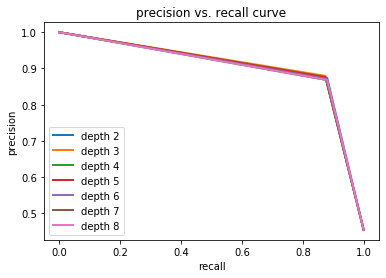

In [816]:
precision = dict()
recall = dict()

for i in range(2,9):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=i)
    rf_pred = cross_val_predict(rf, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    rf_pred2 = np.where(rf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, rf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='depth {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Vary n_trees with max_depth of 2 

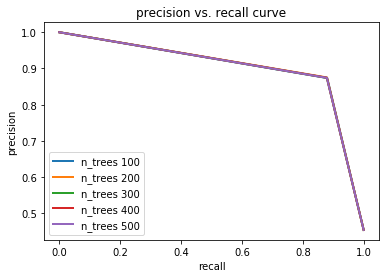

In [817]:
precision = dict()
recall = dict()
trees = [100,200,300,400,500]
for i in trees:
    rf = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=2)
    rf_pred = cross_val_predict(rf, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    rf_pred2 = np.where(rf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, rf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='n_trees {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Table of performance (Precision, Recall, F-score) with varying N-trees, 10-fold CV

In [15]:
precision = []
recall = []
f1 = []

trees = [50,100,200,300]
for i in trees:
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_pred = cross_val_predict(rf, x1, y1, cv=10, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, rf_pred, pos_label="YES")
    recall_s = recall_score(y1, rf_pred, pos_label="YES")
    precision_s = precision_score(y1, rf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

In [16]:
data = {'Precision':precision, 'Recall':recall, "F1":f1}

In [17]:
rf_table = pd.DataFrame(data)
rf_table.index = ['50', '100', '200', '300']
rf_table

,Precision,Recall,F1
50,0.056780,0.047216,0.051558
100,0.054455,0.046512,0.050171
200,0.054276,0.046512,0.050095
300,0.054276,0.046512,0.050095
400,0.054276,0.046512,0.050095


## 2. Balanced Random Forest Classifier with k-fold cross validation

- Will downsample majority class (unstable transcripts)
- For each tree in RF, down-sample the majority class to the same size as the minority class
- Given enough trees, all training data are used, so no loss of information
- Computationally efficient, since each tree only sees a small sample


In [147]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, 
                                     criterion='gini', max_depth=3) #6, 5
k_fold = KFold(n_splits=10, random_state=42, shuffle=True)
sk_fold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) #stratified better for unbalanced datasets

In [617]:
brf_scores = cross_val_score(brf, x1, y1, cv=k_fold, n_jobs=2, pre_dispatch=4)

In [618]:
print("Accuracy: %.2f%%" % (brf_scores.mean()*100.0))

Accuracy: 90.89%


### Obtain confusion matrix for predicted values

In [198]:
brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
labels = np.unique(y1)
conf_mat = confusion_matrix(y1, brf_pred, labels=labels)

In [199]:
pd.DataFrame(conf_mat, index=labels, columns=labels)

,NO,YES
NO,48937,27059
YES,538,2109


In [200]:
print(recall_score(y1, brf_pred, pos_label="YES"))
print(precision_score(y1, brf_pred, pos_label="YES"))

0.7967510389119759
0.0723052660449808


In [834]:
matthew = matthews_corrcoef(y1, brf_pred)
matthew

0.14024853318019925

#### Vary Max_Depth

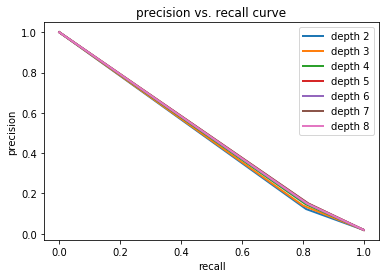

In [544]:
precision = dict()
recall = dict()
k_fold = KFold(n_splits=10, random_state=42, shuffle=True)
for i in range(2,9):
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=i)
    brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    brf_pred2 = np.where(brf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, brf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='depth {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Vary n_trees with max_depth of 2

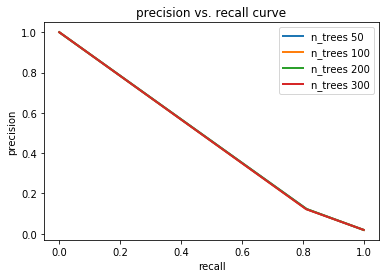

In [545]:
precision = dict()
recall = dict()
trees = [50,100,200,300]
for i in trees:
    brf = BalancedRandomForestClassifier(n_estimators=i, random_state=42, max_depth=2)
    brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    brf_pred2 = np.where(brf_pred =="YES", True, False)
    precision[i], recall[i], _ = precision_recall_curve(y2, brf_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='n_trees {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Table of performance (Precision, Recall, F-score) with max_depth (k-fold CV)

In [667]:
precision = []
recall = []
f1 = []
k_fold = KFold(n_splits=5, random_state=42, shuffle=True)
md = [2,3,4,5,6]
for i in md:
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=i)
    brf_pred = cross_val_predict(brf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, brf_pred, pos_label="YES")
    recall_s = recall_score(y1, brf_pred, pos_label="YES")
    precision_s = precision_score(y1, brf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

In [668]:
data = {'Precision':precision, 'Recall':recall, "F1":f1}

In [669]:
brf_table = pd.DataFrame(data)
brf_table.index = ['2', '3', '4', '5', '6']
brf_table

,Precision,Recall,F1
2,0.062429,0.810351,0.115927
3,0.062471,0.808462,0.115980
4,0.062379,0.802796,0.115763
5,0.062537,0.798262,0.115987
6,0.062190,0.789951,0.115302


#### Table of performance (Precision, Recall, F-score) with varying N-trees (stratified k-fold CV)

In [670]:
precision = []
recall = []
f1 = []

trees = [50,100,200,300, 400, 500]
for i in trees:
    brf = BalancedRandomForestClassifier(n_estimators=i, random_state=42, max_depth=2)
    brf_pred = cross_val_predict(brf, x1, y1, cv=sk_fold, n_jobs=3, pre_dispatch=6)
    f1_s = f1_score(y1, brf_pred, pos_label="YES")
    recall_s = recall_score(y1, brf_pred, pos_label="YES")
    precision_s = precision_score(y1, brf_pred, pos_label="YES")
    f1.append(f1_s)
    recall.append(recall_s)
    precision.append(precision_s)

In [671]:
data = {'Precision':precision, 'Recall':recall, "F1":f1}

In [672]:
brf_table = pd.DataFrame(data)
brf_table.index = ['50', '100', '200', '300','400', '500']
brf_table

,Precision,Recall,F1
50,0.062305,0.806196,0.115670
100,0.062524,0.808462,0.116071
200,0.062467,0.808462,0.115973
300,0.062504,0.808462,0.116036
400,0.062496,0.808462,0.116024
500,0.062485,0.808085,0.116001


In [673]:
tn, fp, fn, tp = confusion_matrix(y1, brf_pred).ravel()
print(f'TN: ',tn)
print(f'FN: ',fn)
print(f'TP: ',tp)
print(f'FP: ',fp)

TN:  43903
FN:  508
TP:  2139
FP:  32093


#### ROC AUC

- AUC ROC = 1 implies the model can perfectly differentiate between the minority and majority classes.
- AUC ROC = 0.5 essentially means the model is equivalent to a random guess

In [665]:
roc_y1 = np.where(y1 =="YES", True, False)
roc_pred = np.where(brf_pred =="YES", True, False)
b_roc_auc = roc_auc_score(roc_y1, roc_pred)

In [666]:
b_roc_auc

0.7147862856433502

## 2. Weighted Random Forest Classifier with k-fold cross validation

- Place a heavier penalty on misclassifying the minority class (stable transcripts), using class_weight
- Ex: {"NO":1, "YES":50} = every sample from class "YES" would count as 50 samples from class "NO", therefore giving more "importance" to your elements from class "YES" (as you have less of those samples surely)

In [151]:
wrf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")
wrf_pred = cross_val_predict(wrf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)

### Obtain confusion matrix for predicted values

In [152]:
accuracy = accuracy_score(y1, wrf_pred)
labels = np.unique(y1)
conf_wrf = confusion_matrix(y1, wrf_pred, labels=labels) #extract confusion matrix

In [153]:
print(accuracy * 100)

96.61254021336929


In [154]:
pd.DataFrame(conf_wrf, index=labels, columns=labels)

,NO,YES
NO,75971,25
YES,2639,8


In [155]:
print(recall_score(y1, wrf_pred, pos_label="YES"))
print(precision_score(y1, wrf_pred, pos_label="YES"))

0.003022289384208538
0.24242424242424243


In [356]:
#### ROC AUC
roc_pred2 = np.where(wrf_pred =="YES", True, False)
b_roc_auc = roc_auc_score(roc_y1, roc_pred2)

NameError: name 'roc_y1' is not defined

In [659]:
b_roc_auc

0.7042435960909986

## 3. SMOTE with k-fold cross validation

- Specialized over-sampling of minority class ("YES")

In [255]:
kf = KFold(n_splits=10)

for fold, (train_index, test_index) in enumerate(kf.split(x1), 1):
    X_train = x1[train_index]
    y_train = y1[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = x1[test_index]
    y_test = y1[test_index]  # See comment on ravel and  y_train
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=100)  # Choose a model here
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'f-score: {f1_score(y_test, y_pred, pos_label="YES")}')
    print(f'recall-score: {recall_score(y_test, model.predict(X_test), pos_label="YES")}')

For fold 1:
Accuracy: 0.7207514944491887
f-score: 0.06380368098159508
recall-score: 0.624
For fold 2:
Accuracy: 0.7339270464804196
f-score: 0.060318828091339934
recall-score: 0.4666666666666667
For fold 3:
Accuracy: 0.7675979016713431
f-score: 0.061113849186791525
recall-score: 0.4397163120567376
For fold 4:
Accuracy: 0.7907515861395803
f-score: 0.08825093035619351
recall-score: 0.5220125786163522
For fold 5:
Accuracy: 0.740971205466081
f-score: 0.04326273095989184
recall-score: 0.5274725274725275
For fold 6:
Accuracy: 0.7941678867740362
f-score: 0.052779337450870295
recall-score: 0.373015873015873
For fold 7:
Accuracy: 0.7875793069790141
f-score: 0.07442849548112705
recall-score: 0.4430379746835443
For fold 8:
Accuracy: 0.7961200585651538
f-score: 0.06386554621848739
recall-score: 0.38
For fold 9:
Accuracy: 0.7508540751586139
f-score: 0.06587374199451053
recall-score: 0.4864864864864865
For fold 10:
Accuracy: 0.7817227916056613
f-score: 0.07353702744691869
recall-score: 0.415204678362

In [164]:
kf_2 = KFold(n_splits=10, shuffle=True)
sk_fold2 = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=50, random_state=13, max_depth=2))

In [515]:
smote_score = cross_val_score(imba_pipeline, x1, y1, cv=kf_2)

In [516]:
print("Accuracy: %.2f%%" % (smote_score.mean()*100.0))

Accuracy: 68.35%


In [201]:
smote_score_pred = cross_val_predict(imba_pipeline, x1, y1, cv=kf_2, n_jobs=3, pre_dispatch=6)

In [202]:
accuracy = accuracy_score(y1, smote_score_pred)
labels = np.unique(y1)
smote_mat = confusion_matrix(y1, smote_score_pred, labels=labels)
pd.DataFrame(smote_mat, index=labels, columns=labels)

,NO,YES
NO,50073,25923
YES,602,2045


In [203]:
print(recall_score(y1, smote_score_pred, pos_label="YES"))
print(precision_score(y1, smote_score_pred, pos_label="YES"))

0.7725727238383076
0.07311927917620137


#### Vary Max_Depth

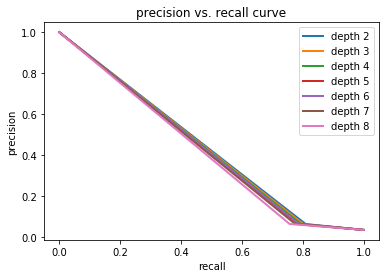

In [702]:
precision = dict()
recall = dict()

p = []
r = []
f = []
kf_2 = KFold(n_splits=5, shuffle=False)

for i in range(2,9):
    imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=50, random_state=13, max_depth=i))
    smote_score_pred = cross_val_predict(imba_pipeline, x1, y1, cv=kf_2, n_jobs=3, pre_dispatch=6)
    y2 = np.where(y1 =="YES", True, False)
    smote_score_pred2 = np.where(smote_score_pred =="YES", True, False)
    
    f1_s = f1_score(y1, smote_score_pred, pos_label="YES")
    recall_s = recall_score(y1, smote_score_pred, pos_label="YES")
    precision_s = precision_score(y1, smote_score_pred, pos_label="YES")
    f.append(f1_s)
    r.append(recall_s)
    p.append(precision_s)
    
    precision[i], recall[i], _ = precision_recall_curve(y2, smote_score_pred2)
    plt.plot(recall[i], precision[i], lw=2, label='depth {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [703]:
data = {'Precision':p, 'Recall':r, "F1":f}

In [704]:
smote_table = pd.DataFrame(data)
smote_table.index = ['2', '3', '4', '5', '6','7','8']
smote_table

,Precision,Recall,F1
2,0.062329,0.809596,0.115747
3,0.062304,0.801662,0.115621
4,0.062246,0.794107,0.115444
5,0.062602,0.784662,0.115953
6,0.062293,0.788440,0.115463
7,0.063017,0.774839,0.116554
8,0.062758,0.756706,0.115904


#### ROC AUC

In [409]:
roc_y1 = np.where(y1 =="YES", True, False)
roc_pred = np.where(smote_score_pred =="YES", True, False)
s_roc_auc = roc_auc_score(roc_y1, roc_pred)

In [410]:
s_roc_auc

0.7142469657701834

#### SMOTEBoost

## 4. Gradient Boosting with k-fold cross validation

#### Compute sample weights

In [174]:
s_weight = compute_sample_weight(class_weight='balanced', y=y1)

#### Run model

In [171]:
grf = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.05)
sk_fold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) #stratified better for unbalanced datasets
k_fold = KFold(n_splits=10, random_state=42, shuffle=True) 

In [255]:
my_model = grf.fit(x1, y1, sample_weight = s_weight)

In [204]:
grf_pred = cross_val_predict(grf, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)

In [205]:
labels = np.unique(y1)
grf_mat = confusion_matrix(y1, grf_pred, labels=labels)
pd.DataFrame(grf_mat, index=labels, columns=labels)

,NO,YES
NO,75990,6
YES,2640,7


In [206]:
print(recall_score(y1, grf_pred, pos_label="YES"))
print(precision_score(y1, grf_pred, pos_label="YES"))

0.0026445032111824707
0.5384615384615384


## 5. Logistic Regression with k-fold cross validation

#### Use OneHotEncoder to convert categorical data to numerical

In [436]:
label_encoder = LabelEncoder()
onehotencoder = OneHotEncoder()
y2= label_encoder.fit_transform(transcript_stability['stability']) 
y3 = onehotencoder.fit_transform(transcript_stability.stability.values.reshape(-1,1)).toarray()

In [433]:
logisticRegr = LogisticRegression(random_state=42)

In [439]:
lr_pred = cross_val_predict(logisticRegr, x1, y2, cv=10, n_jobs=3, pre_dispatch=6)

In [435]:
labels = np.unique(y3)
lr_mat = confusion_matrix(y3, lr_pred, labels=labels)
pd.DataFrame(lr_mat, index=labels, columns=labels)

,0,1
0,80544,0
1,1419,0


## 6. SVC

In [175]:
svc_m = SVC(C=1, random_state=42,kernel='linear')

In [176]:
svc_pred = cross_val_predict(svc_m, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)

KeyboardInterrupt: 

In [1117]:
labels = np.unique(y1) #C=1
svc_mat = confusion_matrix(y1, svc_pred, labels=labels)
pd.DataFrame(svc_mat, index=labels, columns=labels)

,NO,YES
NO,2475,268
YES,296,2351


In [1118]:
print(recall_score(y1, svc_pred, pos_label="YES"))
print(precision_score(y1, svc_pred, pos_label="YES"))

0.8881752927842841
0.8976708667430316


## 7. RUS Boosting

In [240]:
rus = RUSBoostClassifier(n_estimators=300, random_state=42, learning_rate=1.0,sampling_strategy="majority")

In [246]:
rus_pred = cross_val_predict(rus, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)

In [247]:
labels = np.unique(y1) #50
rus_mat = confusion_matrix(y1, rus_pred, labels=labels)
pd.DataFrame(rus_mat, index=labels, columns=labels)

,NO,YES
NO,65763,10233
YES,654,1993


In [248]:
print(recall_score(y1, rus_pred, pos_label="YES"))
print(precision_score(y1, rus_pred, pos_label="YES"))

0.752927842840952
0.16301325044986095


## 8. ADA Boosting

In [249]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)

In [250]:
ada_pred = cross_val_predict(ada, x1, y1, cv=5, n_jobs=3, pre_dispatch=6)

In [251]:
labels = np.unique(y1) #200
ada_mat = confusion_matrix(y1, ada_pred, labels=labels)
pd.DataFrame(ada_mat, index=labels, columns=labels)

,NO,YES
NO,75993,3
YES,2642,5


In [744]:
print(recall_score(y1, ada_pred, pos_label="YES"))
print(precision_score(y1, ada_pred, pos_label="YES"))

0.0
0.0


## 9. Bagging Tree

In [185]:
cart = DecisionTreeClassifier()

In [365]:
bc = BaggingClassifier(base_estimator=cart, n_estimators=100, random_state=42)

In [366]:
bc_pred = cross_val_predict(bc, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)

In [367]:
labels = np.unique(y1)
bc_mat = confusion_matrix(y1, bc_pred, labels=labels)
pd.DataFrame(bc_mat, index=labels, columns=labels)

,NO,YES
NO,2418,325
YES,336,2311


In [368]:
print(recall_score(y1, bc_pred, pos_label="YES"))
print(precision_score(y1, bc_pred, pos_label="YES"))
print(f1_score(y1, bc_pred, pos_label="YES"))

0.8730638458632414
0.8767071320182094
0.8748816960060571


<module 'matplotlib.pyplot' from '/Users/anthmam/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/matplotlib/pyplot.py'>

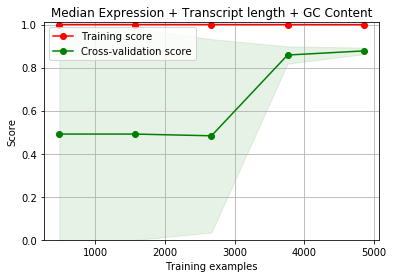

In [351]:
plot_learning_curves(BaggingClassifier(base_estimator=cart, n_estimators=100, random_state=42), x1, y1, title = "Median Expression + Transcript length + GC Content", ylim=(0.0, 1.01), cv=k_fold)

## 10. Voting Classifier (Ensemble combine models)

In [609]:
estimators = []

mod_brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=2, criterion='gini')
estimators.append(('balancedrf', mod_brf))

mod_smote = imba_pipeline = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(n_estimators=100, random_state=13))
estimators.append(('smote', mod_smote))

mod_grad = GradientBoostingClassifier(random_state=42, criterion="friedman_mse", n_estimators=100, learning_rate=0.1)
estimators.append(('gradient', mod_grad))

mod_ada = AdaBoostClassifier(n_estimators=200, random_state=42)
estimators.append(('ada', mod_ada))

mod_bagging = BaggingClassifier(base_estimator=cart, n_estimators=200, random_state=42)
estimators.append(('bagging', mod_bagging))

In [610]:
ensemble = VotingClassifier(estimators)

In [611]:
k_fold = KFold(n_splits=5, random_state=42, shuffle=True) 

In [612]:
results_vc = cross_val_predict(ensemble, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)

In [613]:
labels = np.unique(y1)
vc_mat = confusion_matrix(y1, results_vc, labels=labels)
pd.DataFrame(vc_mat, index=labels, columns=labels)

,NO,YES
NO,70117,530
YES,832,506


In [614]:
print(recall_score(y1, results_vc, pos_label="YES"))
print(precision_score(y1, results_vc, pos_label="YES"))

0.3781763826606876
0.48841698841698844


In [1050]:
tt = ComplementNB()

In [1052]:
nb_pred = cross_val_predict(tt, x1, y1, cv=k_fold, n_jobs=3, pre_dispatch=6)

In [1054]:
labels = np.unique(y1)
nb_mat = confusion_matrix(y1, nb_pred, labels=labels)
pd.DataFrame(nb_mat, index=labels, columns=labels)

,NO,YES
NO,75996,0
YES,2647,0
